In [2]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets

import sklearn.metrics
import pandas as pd
import numpy as np
import datetime

In [3]:
types = {'Unnamed: 0': 'int',
 'mmsi': 'float32',
 'timestamp': 'float32',
 'distance_from_shore': 'float32',
 'distance_from_port': 'float32',
 'speed': 'float16',
 'course': 'float16',
 'lat': 'float16',
 'lon': 'float16',
 'en_DJF': 'float16',
 'en_JFM': 'float16',
 'en_FMA': 'float16',
 'en_MAM': 'float16',
 'en_AMJ': 'float16',
 'en_MJJ': 'float16',
 'en_JJA': 'float16',
 'en_JAS': 'float16',
 'en_ASO': 'float16',
 'en_ASO': 'float16',
 'en_OND': 'float16',
 'en_NDJ': 'float16'}
data1 = pd.read_csv('final_data_table.csv', dtype=types)

In [4]:
month_to_oni = {1: 'en_DJF', 2: 'en_JFM', 3: 'en_FMA', 4: 'en_MAM', 5: 'en_AMJ', 6: 'en_MJJ', 7: 'en_JJA', 8: 'en_JAS', 9: 'en_ASO', 10: 'en_ASO', 11: 'en_OND', 12: 'en_NDJ'}

def getONIVal(row):
    date = datetime.datetime.fromtimestamp(row['timestamp'])
    ONIval = row[month_to_oni[date.month]]
    return ONIval
    
data1['oni_val'] = data1.apply(getONIVal, axis=1)

In [5]:
enc_geartype = pd.get_dummies(data1['geartype'], prefix='', prefix_sep='')

In [6]:
data1 = pd.concat([data1, enc_geartype], axis=1)

In [7]:
data1.sample(5)

,Unnamed: 0,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,...,en_OND,en_NDJ,oni_val,drifting longlines,fixed gear,pole and line,purse seines,trawlers,trollers,unknown
22600661,830815,6.848583e+13,1.439133e+09,591965.187500,6.582512e+05,5.199219,263.750,-30.140625,174.750000,-1.0,...,2.599609,2.599609,1.900391,0,0,0,0,0,0,1
6789377,6789377,8.791928e+13,1.442882e+09,762493.562500,7.728232e+05,4.500000,227.000,-17.421875,1.045898,-1.0,...,2.599609,2.599609,2.199219,1,0,0,0,0,0,0
21871096,101250,6.676526e+12,1.418016e+09,114753.445312,2.003872e+05,10.296875,231.875,10.593750,-78.500000,-1.0,...,0.600098,0.700195,0.700195,0,0,0,0,0,0,1
24675744,2905898,1.851914e+14,1.407948e+09,905368.812500,1.251609e+06,4.398438,171.375,-20.375000,-85.125000,-1.0,...,0.600098,0.700195,0.099976,0,0,0,0,0,0,1
23040995,1271149,9.764633e+13,1.336216e+09,170981.187500,3.065214e+05,2.300781,201.750,66.750000,10.531250,-1.0,...,0.099976,-0.199951,-0.300049,0,0,0,0,0,0,1


In [8]:
fishing = data1[data1['is_fishing']>0]
isnot_fishing = data1[data1['is_fishing']<0]


In [9]:
dataset_balanced = pd.concat([fishing,isnot_fishing[:len(fishing)]])

In [10]:
y = dataset_balanced.pop('is_fishing')

In [11]:
# data_x_segment = dataset_balanced[['distance_from_shore','en_DJF', 'en_JFM','en_FMA','en_MAM', 'en_AMJ', 'en_MJJ','en_JJA','en_JAS','en_ASO','en_OND','en_NDJ']]
data_x_segment = dataset_balanced[['distance_from_shore','oni_val', 'drifting longlines', 'fixed gear', 'pole and line', 'purse seines', 'trawlers', 'trollers', 'unknown']]

In [12]:
y_bool = y.replace({-1.0:False,1:True})

In [13]:
y_bool = y_bool.astype(bool)

In [14]:
y_bool.value_counts()

True     257876
False    257876
Name: is_fishing, dtype: int64

In [15]:
print(len(data_x_segment))
print(len(y_bool))

515752
515752


In [16]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data_x_segment, y_bool)

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(386814, 9) (128938, 9) (386814,) (128938,)


In [18]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(verbose=1)
regressor.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.8s finished


RandomForestClassifier(verbose=1)

In [19]:
y_hat = regressor.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy score 0.965308908157409


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


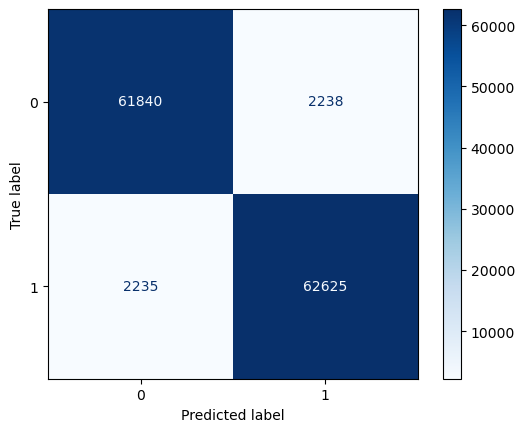

[[61840  2238]
 [ 2235 62625]]
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     64078
        True       0.97      0.97      0.97     64860

    accuracy                           0.97    128938
   macro avg       0.97      0.97      0.97    128938
weighted avg       0.97      0.97      0.97    128938



In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()
print(cm)
print(classification_report(y_test, y_hat))

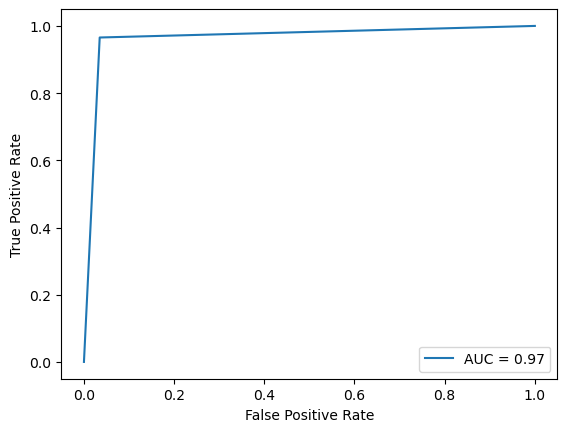

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

plt.show()

In [133]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, regressor.predict_proba(X_test), multi_class='ovr')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


ValueError: continuous format is not supported

In [23]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score

In [24]:
# K MEANS
X_train1, X_test1, y_train1, y_test1 = sklearn.model_selection.train_test_split(data_x_segment, y_bool)
n_clusters = len(np.unique(y_train1))
clf = KMeans(n_clusters = n_clusters, random_state=42)
clf.fit(X_train1)
y_labels_train1 = clf.labels_
y_labels_test1 = clf.predict(X_test1)
X_train2 = X_train1
X_test2 = X_test1
X_train1 = y_labels_train1[:, np.newaxis]
X_test1 = y_labels_test1[:, np.newaxis]
X_train2['km_clust'] = y_labels_train1
X_test2['km_clust'] = y_labels_test1
print('Accuracy: {}'.format(accuracy_score(y_test1, y_labels_test1)))

Accuracy: 0.48838201306054074


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


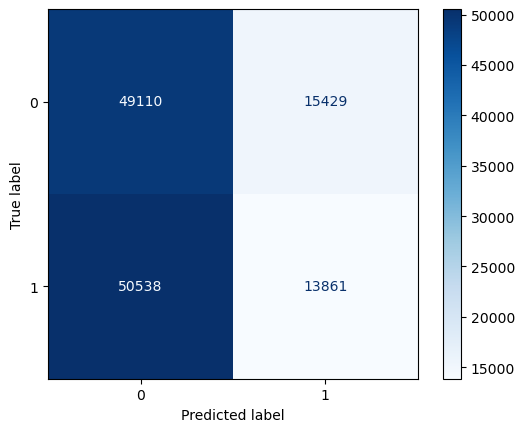

[[49110 15429]
 [50538 13861]]
              precision    recall  f1-score   support

       False       0.49      0.76      0.60     64539
        True       0.47      0.22      0.30     64399

    accuracy                           0.49    128938
   macro avg       0.48      0.49      0.45    128938
weighted avg       0.48      0.49      0.45    128938



In [25]:

cm = confusion_matrix(y_test1, y_labels_test1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()
print(cm)
print(classification_report(y_test1, y_labels_test1))

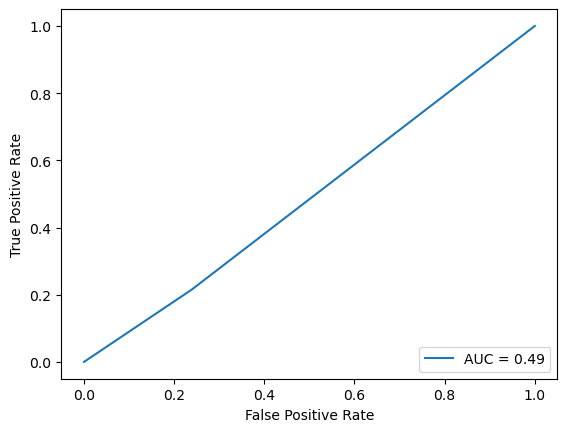

In [26]:
fpr, tpr, thresholds = roc_curve(y_test1, y_labels_test1)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [ ]:
# prediction without KMEANS
model = LogisticRegression(random_state=42)
model.fit(X_train1, y_train1)
y_pred1 = model.predict(X_test1)
print('Accuracy: {}'.format(accuracy_score(y_test1, y_pred1)))

Accuracy: 0.5116179869394593
Train Accuracy: 0.5070679965047801


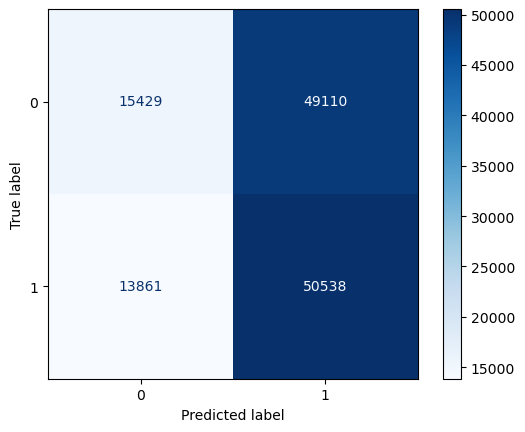

[[15429 49110]
 [13861 50538]]
              precision    recall  f1-score   support

       False       0.53      0.24      0.33     64539
        True       0.51      0.78      0.62     64399

    accuracy                           0.51    128938
   macro avg       0.52      0.51      0.47    128938
weighted avg       0.52      0.51      0.47    128938



In [28]:
cm = confusion_matrix(y_test1, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()
print(cm)
print(classification_report(y_test1, y_pred1))

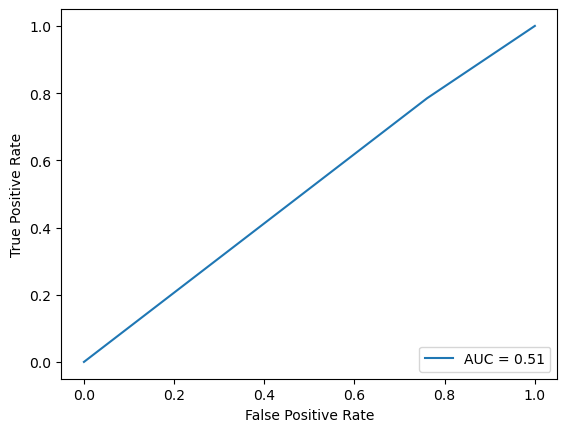

In [29]:
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [30]:
# prediction with cluster as feature
model = LogisticRegression(random_state=42)
model.fit(X_train2, y_train1)
y_pred2 = model.predict(X_test2)
print('Accuracy: {}'.format(accuracy_score(y_test1, y_pred2)))

Accuracy: 0.5028153065814578


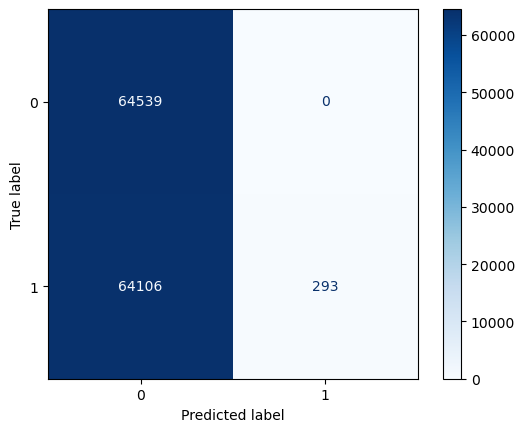

[[64539     0]
 [64106   293]]
              precision    recall  f1-score   support

       False       0.50      1.00      0.67     64539
        True       1.00      0.00      0.01     64399

    accuracy                           0.50    128938
   macro avg       0.75      0.50      0.34    128938
weighted avg       0.75      0.50      0.34    128938



In [31]:
cm = confusion_matrix(y_test1, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()
print(cm)
print(classification_report(y_test1, y_pred2))

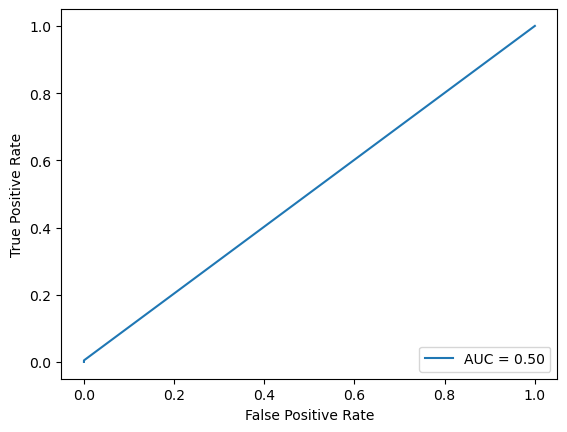

In [32]:
fpr, tpr, thresholds = roc_curve(y_test1, y_pred2)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [33]:
# prediction with MLP Neural Net
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, y_train)
clf.predict_proba(X_test)
clf.predict(X_test)
clf.score(X_test, y_test)


0.6900293164156416

0.6900293164156416


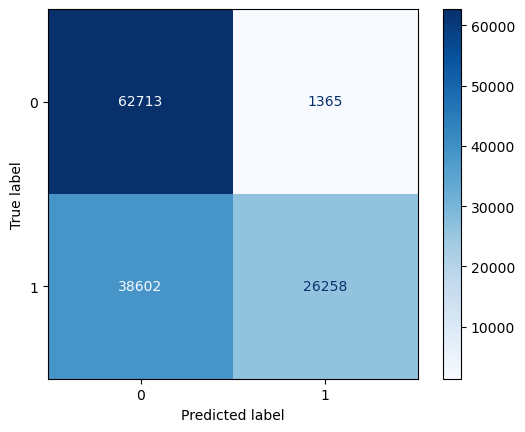

[[62713  1365]
 [38602 26258]]
              precision    recall  f1-score   support

       False       0.62      0.98      0.76     64078
        True       0.95      0.40      0.57     64860

    accuracy                           0.69    128938
   macro avg       0.78      0.69      0.66    128938
weighted avg       0.79      0.69      0.66    128938



In [34]:
y_hat = clf.predict(X_test)
print(clf.score(X_test, y_test))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()
print(cm)
print(classification_report(y_test, y_hat))

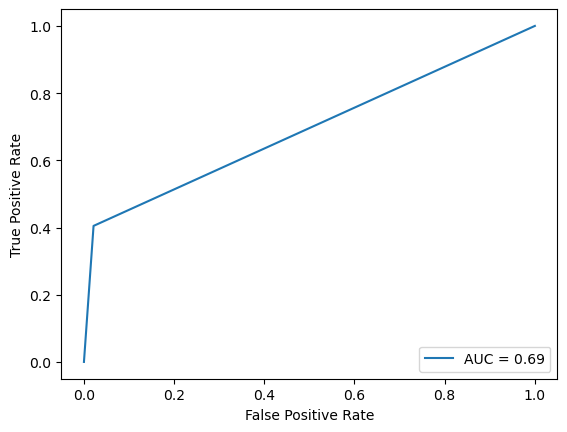

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [36]:
# prediction with MLP Neural Net w hyperparameters tuned
clf = MLPClassifier(random_state=1, max_iter=100, verbose=True, alpha=.05).fit(X_train, y_train)
clf.predict_proba(X_test)
clf.predict(X_test)
clf.score(X_test, y_test)


Iteration 1, loss = 14.50666501
Iteration 2, loss = 14.12973345
Iteration 3, loss = 14.12186000
Iteration 4, loss = 13.81241484
Iteration 5, loss = 13.93033405
Iteration 6, loss = 13.99688067
Iteration 7, loss = 13.72696567
Iteration 8, loss = 13.83111510
Iteration 9, loss = 13.71478045
Iteration 10, loss = 13.74217920
Iteration 11, loss = 13.72543651
Iteration 12, loss = 13.66251430
Iteration 13, loss = 13.74238425
Iteration 14, loss = 13.90196620
Iteration 15, loss = 13.56821271
Iteration 16, loss = 13.63393016
Iteration 17, loss = 13.84172330
Iteration 18, loss = 13.63205873
Iteration 19, loss = 13.74289303
Iteration 20, loss = 13.79702361
Iteration 21, loss = 13.73168951
Iteration 22, loss = 13.64530700
Iteration 23, loss = 13.71013960
Iteration 24, loss = 13.50162910
Iteration 25, loss = 13.51777434
Iteration 26, loss = 13.58372352
Iteration 27, loss = 13.55519941
Iteration 28, loss = 13.26436918
Iteration 29, loss = 13.53301893
Iteration 30, loss = 13.24922173
Iteration 31, loss 

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.5805891203524174

0.5805891203524174


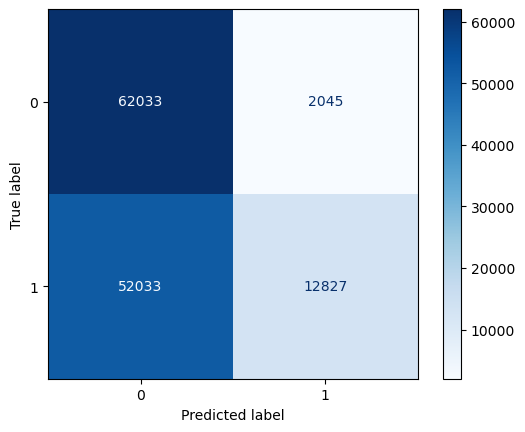

[[62033  2045]
 [52033 12827]]
              precision    recall  f1-score   support

       False       0.54      0.97      0.70     64078
        True       0.86      0.20      0.32     64860

    accuracy                           0.58    128938
   macro avg       0.70      0.58      0.51    128938
weighted avg       0.70      0.58      0.51    128938



In [37]:
y_hat = clf.predict(X_test)
print(clf.score(X_test, y_test))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()
print(cm)
print(classification_report(y_test, y_hat))

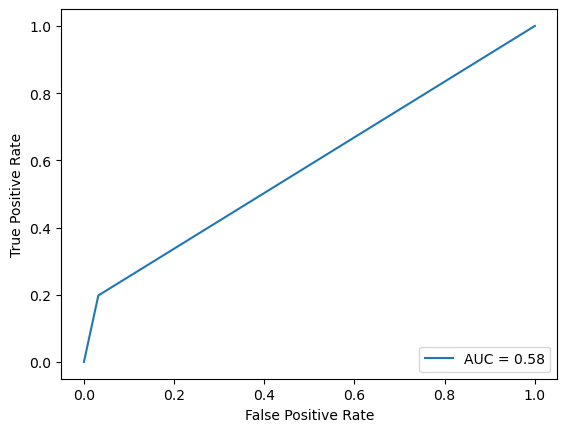

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# parameter_space = {
#     'hidden_layer_sizes': [(25,30,25), (25,50,25), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }
# mlp = MLPClassifier(random_state=1, max_iter=100, verbose=True)
# clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
# clf.fit(X_train, y_train)